Preprocessing

In [2]:
import numpy as np
import cv2
import os

class SimplePreprocessor:
  def __init__(self, width, height, inter=cv2.INTER_AREA):
    self.width = width
    self.height = height
    self.inter = inter

  # resize the image to a fixed size, ignoring the aspect ratio
  def preprocess(self, image):
    return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to
                # the image
                for p in self.preprocessors:
                    image = p.preprocess(image)

            # treat our processed image as a "feature vector"
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every `verbose` images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1,
                    len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

Helper Functions

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def sigmoid_activation(x):
	# compute the sigmoid activation value for a given input
	return 1.0 / (1 + np.exp(-x))

def sigmoid_deriv(x):
	# compute the derivative of the sigmoid function ASSUMING
	# that the input `x` has already been passed through the sigmoid
	# activation function
	return x * (1 - x)

def predict(X, W):
	# take the dot product between our features and weight matrix
	preds = sigmoid_activation(X.dot(W))

	# apply a step function to threshold the outputs to binary
	# class labels
	preds[preds <= 0.5] = 0
	preds[preds > 0] = 1

	# return the predictions
	return preds

def next_batch(X, y, batchSize):
    # loop over our dataset `X` in mini-batches, yielding a tuple of
    # the current batched data and labels
    for i in np.arange(0, X.shape[0], batchSize):
        yield (X[i:i + batchSize], y[i:i + batchSize])

Gradient Descent

In [6]:
def train_gd(epochs=100, alpha=0.01):
    # generate a 2-class classification problem with 1,000 data points,
    # where each data point is a 2D feature vector
    (X, y) = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.5, random_state=1)
    y = y.reshape((y.shape[0], 1))

    # insert a column of 1's as the last entry in the feature
    # matrix -- this little trick allows us to treat the bias
    # as a trainable parameter within the weight matrix
    X = np.c_[X, np.ones((X.shape[0]))]

    # partition the data into training and testing splits using 50% of
    # the data for training and the remaining 50% for testing
    (trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.5, random_state=42)

    # initialize our weight matrix and list of losses
    print("[INFO] training...")
    W = np.random.randn(X.shape[1], 1)
    losses = []

    # loop over the desired number of epochs
    for epoch in np.arange(0, epochs):
        # take the dot product between our features `X` and the weight
        # matrix `W`, then pass this value through our sigmoid activation
        # function, thereby giving us our predictions on the dataset
        preds = sigmoid_activation(trainX.dot(W))

        # now that we have our predictions, we need to determine the
        # `error`, which is the difference between our predictions and
        # the true values
        error = preds - trainY
        loss = np.sum(error ** 2)
        losses.append(loss)

        # the gradient descent update is the dot product between our
        # (1) features and (2) the error of the sigmoid derivative of
        # our predictions
        d = error * sigmoid_deriv(preds)
        gradient = trainX.T.dot(d)

        # in the update stage, all we need to do is "nudge" the weight
        # matrix in the negative direction of the gradient (hence the
        # term "gradient descent" by taking a small step towards a set
        # of "more optimal" parameters
        W += -alpha * gradient

        # check to see if an update should be displayed
        if epoch == 0 or (epoch + 1) % 5 == 0:
            print("[INFO] epoch={}, loss={:.7f}".format(int(epoch + 1), loss))

    # evaluate our model
    print("[INFO] evaluating...")
    preds = predict(testX, W)
    print(classification_report(testY, preds))

    # plot the (testing) classification data
    plt.style.use("ggplot")
    plt.figure()
    plt.title("Data")
    plt.scatter(testX[:, 0], testX[:, 1], marker="o", c=testY[:, 0], s=30)

    # construct a figure that plots the loss over time
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.show()

[INFO] training...
[INFO] epoch=1, loss=252.6169444
[INFO] epoch=5, loss=9.7616931
[INFO] epoch=10, loss=6.2677985
[INFO] epoch=15, loss=4.2289094
[INFO] epoch=20, loss=2.6955915
[INFO] epoch=25, loss=1.8444629
[INFO] epoch=30, loss=1.4024719
[INFO] epoch=35, loss=1.1514843
[INFO] epoch=40, loss=0.9917082
[INFO] epoch=45, loss=0.8803278
[INFO] epoch=50, loss=0.7974704
[INFO] epoch=55, loss=0.7329608
[INFO] epoch=60, loss=0.6811266
[INFO] epoch=65, loss=0.6385837
[INFO] epoch=70, loss=0.6032021
[INFO] epoch=75, loss=0.5735747
[INFO] epoch=80, loss=0.5487196
[INFO] epoch=85, loss=0.5278985
[INFO] epoch=90, loss=0.5105022
[INFO] epoch=95, loss=0.4959833
[INFO] epoch=100, loss=0.4838266
[INFO] evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg   

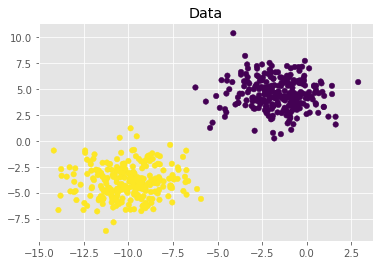

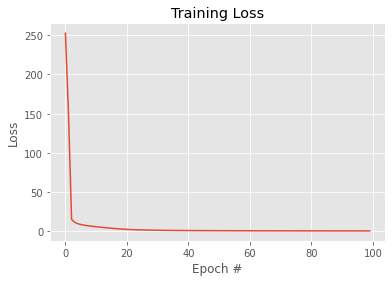

In [8]:
train_gd(epochs=100, alpha=0.01)

Stochastic Gradient Descent

In [13]:
def train_sgd(epochs=100, alpha=0.01, batch_size=32):
    # generate a 2-class classification problem with 1,000 data points,
    # where each data point is a 2D feature vector
    (X, y) = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.5, random_state=1)
    y = y.reshape((y.shape[0], 1))

    # insert a column of 1's as the last entry in the feature
    # matrix -- this little trick allows us to treat the bias
    # as a trainable parameter within the weight matrix
    X = np.c_[X, np.ones((X.shape[0]))]

    # partition the data into training and testing splits using 50% of
    # the data for training and the remaining 50% for testing
    (trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.5, random_state=42)

    # initialize our weight matrix and list of losses
    print("[INFO] training...")
    W = np.random.randn(X.shape[1], 1)
    losses = []

    # loop over the desired number of epochs
    for epoch in np.arange(0, epochs):
        # initialize the total loss for the epoch
        epochLoss = []

        # loop over our data in batches
        for (batchX, batchY) in next_batch(trainX, trainY, batch_size):
            # take the dot product between our current batch of features
            # and the weight matrix, then pass this value through our
            # activation function
            preds = sigmoid_activation(batchX.dot(W))

            # now that we have our predictions, we need to determine the
            # `error`, which is the difference between our predictions
            # and the true values
            error = preds - batchY
            epochLoss.append(np.sum(error ** 2))

            # the gradient descent update is the dot product between our
            # (1) current batch and (2) the error of the sigmoid
            # derivative of our predictions
            d = error * sigmoid_deriv(preds)
            gradient = batchX.T.dot(d)

            # in the update stage, all we need to do is "nudge" the
            # weight matrix in the negative direction of the gradient
            # (hence the term "gradient descent" by taking a small step
            # towards a set of "more optimal" parameters
            W += -alpha * gradient

        # update our loss history by taking the average loss across all
        # batches
        loss = np.average(epochLoss)
        losses.append(loss)

        # check to see if an update should be displayed
        if epoch == 0 or (epoch + 1) % 5 == 0:
            print("[INFO] epoch={}, loss={:.7f}".format(int(epoch + 1), loss))

    # evaluate our model
    print("[INFO] evaluating...")
    preds = predict(testX, W)
    print(classification_report(testY, preds))

    # plot the (testing) classification data
    plt.style.use("ggplot")
    plt.figure()
    plt.title("Data")
    plt.scatter(testX[:, 0], testX[:, 1], marker="o", c=testY[:, 0], s=30)

    # construct a figure that plots the loss over time
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.show()

[INFO] training...
[INFO] epoch=1, loss=13.8465559
[INFO] epoch=5, loss=0.1553880
[INFO] epoch=10, loss=0.0733129
[INFO] epoch=15, loss=0.0579548
[INFO] epoch=20, loss=0.0494610
[INFO] epoch=25, loss=0.0436384
[INFO] epoch=30, loss=0.0393289
[INFO] epoch=35, loss=0.0359791
[INFO] epoch=40, loss=0.0332820
[INFO] epoch=45, loss=0.0310522
[INFO] epoch=50, loss=0.0291699
[INFO] epoch=55, loss=0.0275545
[INFO] epoch=60, loss=0.0261491
[INFO] epoch=65, loss=0.0249123
[INFO] epoch=70, loss=0.0238133
[INFO] epoch=75, loss=0.0228288
[INFO] epoch=80, loss=0.0219404
[INFO] epoch=85, loss=0.0211336
[INFO] epoch=90, loss=0.0203968
[INFO] epoch=95, loss=0.0197208
[INFO] epoch=100, loss=0.0190976
[INFO] evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg    

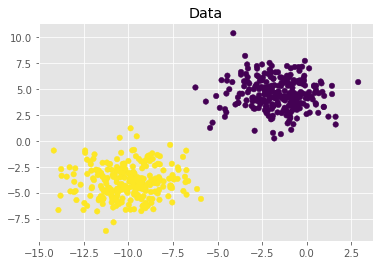

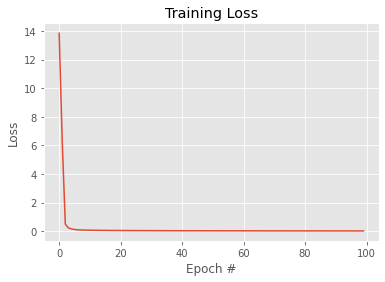

In [14]:
train_sgd()